<Axes: xlabel='timestamp'>

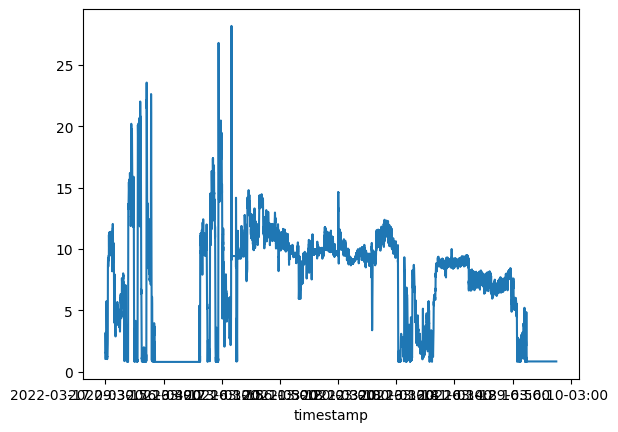

In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

df = pd.read_csv('../../2022/boat_data_1s.csv')
df = df.set_index('timestamp')

# Filter
df['gps_speed'] = df['gps_speed'].rolling(10, center=True).mean()
df = df[(df['gps_speed'] > 0.8) & (df['gps_speed'] < 30)]
df = df.dropna()

df.columns

df['gps_speed'].plot()

## Speed model: unit normalization + steady-state dataset

- `gps_speed` is treated as **km/h** for the final mapping. We compute `V_mps = gps_speed / 3.6` only to estimate `dV/dt` for the steady-state filter.
- Electrical power is taken as `batt_po` (W). It is only used to optionally filter out power transients (`dP/dt`).
- The steady-state subset filters out acceleration transients using thresholds on `dV/dt` (and optionally `dP/dt`).

**[ASSUMPTION]** The file `boat_data_1s.csv` is sampled at ~1 Hz; if timestamps are not uniform, `dt_s` is estimated from the index.


Estimated dt_s: 1.0
P/(V*I) ratio median: 1.0000000033786511
steady points: 14842 of 19376


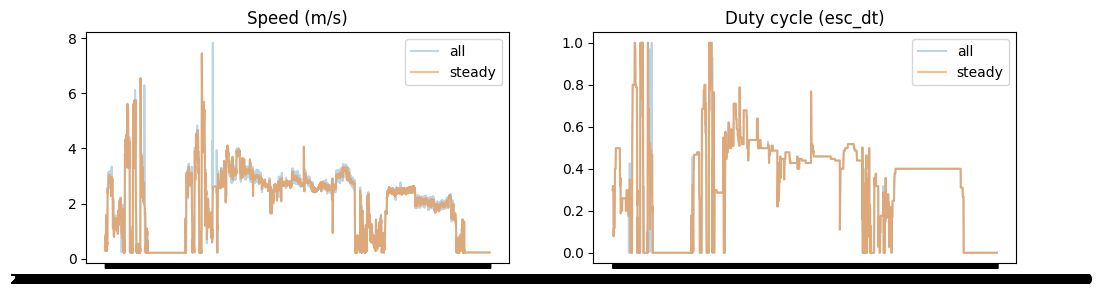

In [3]:
import numpy as np

# Units
df['V_mps'] = df['gps_speed'] / 3.6

# Time step estimate (s)
idx = df.index.to_numpy()
dt_s = 1.0
try:
    if np.issubdtype(idx.dtype, np.number):
        dt_s = float(np.nanmedian(np.diff(idx)))
    elif np.issubdtype(idx.dtype, np.datetime64):
        dt_s = float(np.nanmedian(np.diff(idx).astype('timedelta64[ns]').astype(np.float64))) / 1e9
except Exception:
    dt_s = 1.0
print('Estimated dt_s:', dt_s)

df['P_elec_W'] = df['batt_po']
df['P_elec_W_from_VI'] = df['batt_v'] * df['batt_io']
ratio = (df['P_elec_W'] / df['P_elec_W_from_VI']).replace([np.inf, -np.inf], np.nan)
print('P/(V*I) ratio median:', float(np.nanmedian(ratio)))

# Steady-state filter (tune thresholds as needed)
V_DOT_MAX_M_PER_S2 = 0.05

dv_dt = df['V_mps'].diff() / dt_s
steady_mask = dv_dt.abs().fillna(0) < V_DOT_MAX_M_PER_S2

df_ss = df[steady_mask].copy()
print('steady points:', len(df_ss), 'of', len(df))

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(df['V_mps'], alpha=0.3, label='all')
ax[0].plot(df_ss['V_mps'], alpha=0.5, label='steady')
ax[0].set_title('Speed (m/s)')
ax[0].legend()
ax[1].plot(df['esc_dt'], alpha=0.3, label='all')
ax[1].plot(df_ss['esc_dt'], alpha=0.5, label='steady')
ax[1].set_title('Duty cycle (esc_dt)')
ax[1].legend()
plt.show()


## 2022 competition: motor voltage proxy (`motor_v`) → boat speed map

Main output: a function `speed_kmh_from_motor_v_2022(motor_v)` calibrated from the 2022 dataset.

Rationale:
- Duty cycle alone (`esc_dt`) ignores battery sag. Using `motor_v = batt_v * esc_dt` (a voltage proxy) is typically more transferable across runs with different `batt_v` **[ASSUMPTION]**.

Steps:
- Use the steady-state subset (`df_ss`) to reduce transient bias (low |dV/dt|; optionally low |dP/dt|).
- Compute `motor_v = batt_v * esc_dt` on the steady subset.
- Bin `motor_v` and take the **median** boat speed per bin.
- Fit a *monotone* interpolator (PCHIP) through the binned medians (monotonicity enforced by cumulative max).

**[ASSUMPTION]** `gps_speed` is in km/h in `boat_data_1s.csv`.


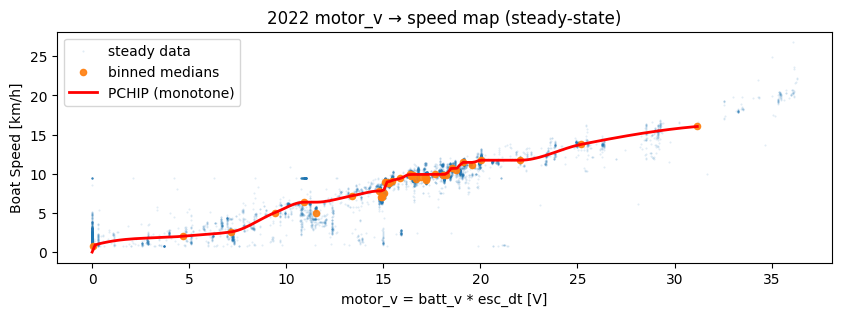

x_mv (V): [0.0, 0.0391306927712643, 4.699887943152394, 7.167215005760231, 9.42944745531948, 10.91623828112454, 11.542608195510311, 13.379603968130322, 14.790383846222891, 14.858067852638829, 14.944401821240481, 15.022728667561914, 15.085570728890628, 15.141434948472389, 15.216913112435574, 15.27675401961455, 15.420380292124245, 15.87279447785217, 16.374037724220766, 16.4455826766984, 16.50929259040106, 16.660990276532363, 16.926718411935212, 17.163178175690042, 17.194760949232304, 17.210870306356004, 17.668584239135296, 18.08361715530692, 18.216890056508607, 18.51700301036315, 18.767170615717685, 19.096637613536597, 19.58648259345597, 20.030845908945363, 22.042773789194726, 25.185381650981792, 31.171794158983666]
y_mono (km/h): [0.0, 0.8390322336497046, 2.033750236410566, 2.5796973247437824, 5.046044531042401, 6.368125830143711, 6.368125830143711, 7.1746694014328485, 7.795891874447376, 7.795891874447376, 7.795891874447376, 7.795891874447376, 8.9502238622014, 8.958202944432143, 8.958202

In [4]:
from scipy.interpolate import PchipInterpolator

df_ss = df_ss.copy()
df_ss['motor_v'] = df_ss['batt_v'] * df_ss['esc_dt']

# Bin motor_v (voltage proxy) into bins; use quantiles to keep counts balanced
N_BINS = 50
motor_v = df_ss['motor_v'].to_numpy(dtype=float)
mv_edges = np.quantile(motor_v[~np.isnan(motor_v)], np.linspace(0, 1, N_BINS + 1))
mv_edges = np.unique(mv_edges)
if len(mv_edges) < 5:
    mv_edges = np.linspace(np.nanmin(motor_v), np.nanmax(motor_v), 21)

df_ss['mv_bin'] = pd.cut(df_ss['motor_v'], bins=mv_edges, labels=False, include_lowest=True)

grouped = df_ss.groupby('mv_bin').agg(
    motor_v_mean=('motor_v', 'mean'),
    speed_kmh_median=('gps_speed', 'median'),
    speed_kmh_std=('gps_speed', 'std'),
    count=('gps_speed', 'size')
)
grouped = grouped[grouped['count'] > 50].dropna()

x_mv_raw = grouped['motor_v_mean'].to_numpy(dtype=float)
y_raw = grouped['speed_kmh_median'].to_numpy(dtype=float)
order = np.argsort(x_mv_raw)
x_mv_raw = x_mv_raw[order]
y_raw = y_raw[order]

# Enforce non-decreasing median speed vs motor_v (reduces noise-induced wiggles)
y_mono = np.maximum.accumulate(y_raw)
x_mv = x_mv_raw.copy()

# Force (motor_v=0) -> (speed=0) anchor for later application to 2020 logs
# [ASSUMPTION] When motor command is ~0, boat speed should be ~0.
if len(x_mv) > 0 and float(np.min(x_mv)) <= 1e-9:
    y_mono[0] = 0.0
else:
    x_mv = np.insert(x_mv, 0, 0.0)
    y_mono = np.insert(y_mono, 0, 0.0)

MOTOR_V_MIN = float(np.min(x_mv))
MOTOR_V_MAX = float(np.max(x_mv))

pchip_mv = PchipInterpolator(x_mv, y_mono, extrapolate=False)

def speed_kmh_from_motor_v_2022(motor_v, clip=False):
    motor_v = np.asarray(motor_v, dtype=float)
    if clip:
        mv = np.clip(motor_v, MOTOR_V_MIN, MOTOR_V_MAX)
        return pchip_mv(mv)
    out = np.full_like(motor_v, np.nan, dtype=float)
    mask = np.isfinite(motor_v) & (motor_v >= MOTOR_V_MIN) & (motor_v <= MOTOR_V_MAX)
    out[mask] = pchip_mv(motor_v[mask])
    return out

def speed_kmh_from_esc_dt_and_batt_v_2022(esc_dt, batt_v, clip=False):
    esc_dt = np.asarray(esc_dt, dtype=float)
    batt_v = np.asarray(batt_v, dtype=float)
    return speed_kmh_from_motor_v_2022(esc_dt * batt_v, clip=clip)

# Visual check
mv_grid = np.linspace(float(np.min(x_mv)), float(np.max(x_mv)), 200)
plt.figure(figsize=(10, 3))
plt.scatter(df_ss['motor_v'], df_ss['gps_speed'], s=0.2, alpha=0.15, label='steady data')
plt.scatter(x_mv_raw, y_raw, s=20, alpha=0.9, label='binned medians')
plt.plot(mv_grid, speed_kmh_from_motor_v_2022(mv_grid, clip=True), 'r', linewidth=2, label='PCHIP (monotone)')
plt.xlabel('motor_v = batt_v * esc_dt [V]')
plt.ylabel('Boat Speed [km/h]')
plt.title('2022 motor_v → speed map (steady-state)')
plt.legend()
plt.show()

# Export-friendly arrays
print('x_mv (V):', x_mv.tolist())
print('y_mono (km/h):', y_mono.tolist())


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

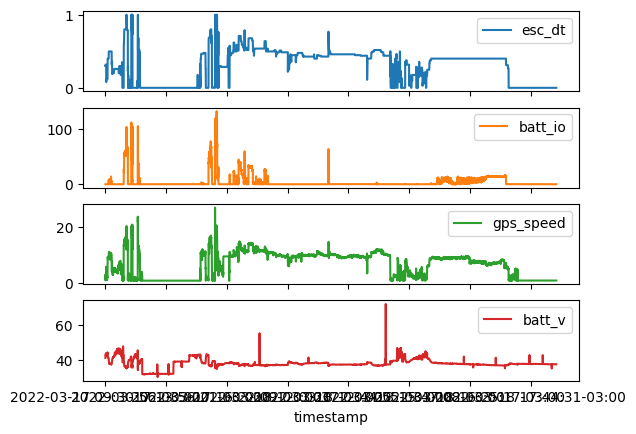

In [5]:
df_ss[['esc_dt', 'batt_io', 'gps_speed', 'batt_v']].plot(subplots=True)

In [6]:
# Summary table of binned steady-state data
grouped


,motor_v_mean,speed_kmh_median,speed_kmh_std,count
mv_bin,,,,
0,0.039131,0.839032,0.788754,4453
1,4.699888,2.033750,1.233931,297
2,7.167215,2.579697,1.150195,296
3,9.429447,5.046045,1.566728,297
4,10.916238,6.368126,2.366403,297
5,11.542608,4.984007,1.105132,297
6,13.379604,7.174669,2.363559,297
7,14.790384,7.795892,0.695259,297
8,14.858068,7.033821,0.354150,296


RMSE (km/h): 1.2455859540944034
MAE  (km/h): 0.804553901301509


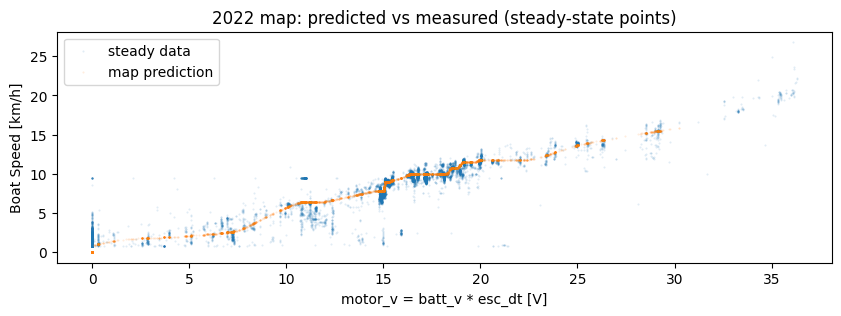

In [7]:
# Quick accuracy check of the 2022 map on the same (steady) dataset
motor_v_ss = (df_ss['batt_v'] * df_ss['esc_dt']).to_numpy(dtype=float)
speed_hat = speed_kmh_from_motor_v_2022(motor_v_ss)
speed_true = df_ss['gps_speed'].to_numpy(dtype=float)
rmse = float(np.sqrt(np.nanmean((speed_hat - speed_true) ** 2)))
mae = float(np.nanmean(np.abs(speed_hat - speed_true)))
print('RMSE (km/h):', rmse)
print('MAE  (km/h):', mae)

plt.figure(figsize=(10, 3))
plt.scatter(motor_v_ss, speed_true, s=0.2, alpha=0.15, label='steady data')
plt.scatter(motor_v_ss, speed_hat, s=0.2, alpha=0.15, label='map prediction')
plt.xlabel('motor_v = batt_v * esc_dt [V]')
plt.ylabel('Boat Speed [km/h]')
plt.title('2022 map: predicted vs measured (steady-state points)')
plt.legend()
plt.show()


## Comparison: Prelimina (calm-water resistance) vs inferred resistance from 2022 logs

The file `../hull/data/prelimia.csv` contains a resistance curve $R_T(V)$ from the Prelimina tool.

From the 2022 steady-state logs we can compute $P_{elec}/V$ (units N), which relates to resistance by:
$\displaystyle R_T(V) \approx \eta_{total} \cdot \frac{P_{elec}}{V}$

We estimate a single scalar $\eta_{total}$ by least squares to align the magnitudes and compare the *shape* of the curves.

**[ASSUMPTION]** Prelimina resistance corresponds to the same hull/displacement and calm-water conditions; wind/current and dynamic effects are ignored.
**[ASSUMPTION]** $\eta_{total}$ is approximately constant over the compared speed range.


eta_hat (scalar fit): 0.35350115939004223


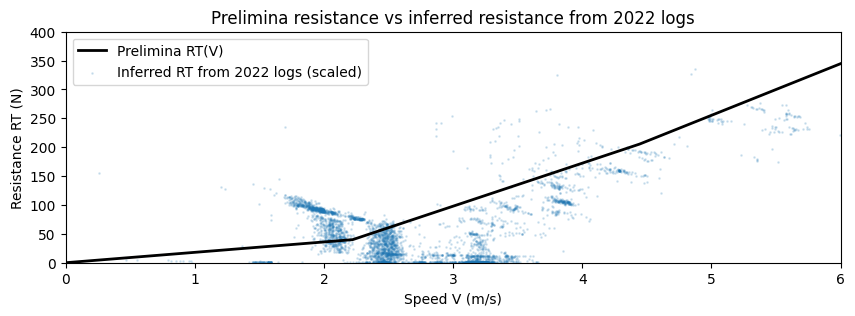

In [14]:
prelimia_path = '../hull/data/prelimia.csv'
df_pre = pd.read_csv(prelimia_path)
V_pre = pd.to_numeric(df_pre['V (m/s)'], errors='coerce').to_numpy(dtype=float)
RT_pre = pd.to_numeric(df_pre['RT (N)'], errors='coerce').to_numpy(dtype=float)
mask_pre = np.isfinite(V_pre) & np.isfinite(RT_pre)
V_pre = V_pre[mask_pre]
RT_pre = RT_pre[mask_pre]
order = np.argsort(V_pre)
V_pre = V_pre[order]
RT_pre = RT_pre[order]

V_ss = df_ss['V_mps'].to_numpy(dtype=float)
P_ss = df_ss['P_elec_W'].to_numpy(dtype=float)
mask = np.isfinite(V_ss) & np.isfinite(P_ss) & (V_ss > 0.2) & (P_ss > 0)
V_ss = V_ss[mask]
P_ss = P_ss[mask]

# R_over_eta has units N (since W/(m/s) = N) and equals RT/eta_total under the constant-efficiency assumption
R_over_eta = P_ss / V_ss

# Interpolate Prelimina resistance at measured speeds (clip to available range)
V_clip = np.clip(V_ss, float(np.min(V_pre)), float(np.max(V_pre)))
RT_at = np.interp(V_clip, V_pre, RT_pre)

# Least-squares eta estimate: minimize || RT_at - eta * (P/V) ||
den = float(np.dot(R_over_eta, R_over_eta))
eta_hat = float(np.dot(R_over_eta, RT_at) / den) if den > 0 else float('nan')
print('eta_hat (scalar fit):', eta_hat)

RT_est = eta_hat * R_over_eta

plt.figure(figsize=(10, 3))
plt.plot(V_pre, RT_pre, 'k', linewidth=2, label='Prelimina RT(V)')
plt.scatter(V_ss, RT_est, s=1, alpha=0.15, label='Inferred RT from 2022 logs (scaled)')
plt.xlabel('Speed V (m/s)')
plt.ylabel('Resistance RT (N)')
plt.title('Prelimina resistance vs inferred resistance from 2022 logs')
plt.xlim([0, 6])
plt.ylim([0, 400])
plt.legend()
plt.show()


## 2020 dataset: estimate boat speed using the 2022 motor_v → speed map

The 2020 dataset `../boat_data_50ms.csv` is large (~2.5 GB). The code below loads it (no chunking) and aggregates to **1-second** resolution.

Implementation details:
- Use `ESC Duty Cycle` (or alias `ESC Duty Cycle (Reconstructed)`).
- Use `Battery Pack Voltage` (or alias `Battery Pack Voltage (MCS)`).
- Compute `motor_v_2020 = batt_v_2020 * esc_dt_2020` and apply `speed_kmh_from_motor_v_2022(motor_v_2020)`.

Note: this may require a lot of RAM; if it crashes, we can revert to chunking.

**[ASSUMPTION]** The `timestamp` column is a string formatted like `YYYY-MM-DD HH:MM:SS.sss`, so `timestamp[:19]` identifies the second.


2020 batt_v median (raw): 38.588646 -> scale: 1.0
motor_v domain [V]: 0.0 to 31.171794158983666
fraction of samples within domain: 0.996678982261597


,ts_s,duty_mean,batt_v_mean,motor_v_mean,speed_est_kmh,n,timestamp
0,2020-01-29 11:56:53,0.0,38.664608,0.0,0.0,7,2020-01-29 11:56:53
1,2020-01-29 11:56:54,0.0,38.628181,0.0,0.0,20,2020-01-29 11:56:54
2,2020-01-29 11:56:55,0.0,38.661155,0.0,0.0,20,2020-01-29 11:56:55
3,2020-01-29 11:56:56,0.0,38.661760,0.0,0.0,20,2020-01-29 11:56:56
4,2020-01-29 11:56:57,0.0,38.614917,0.0,0.0,20,2020-01-29 11:56:57


,duty_mean,batt_v_mean,motor_v_mean,speed_est_kmh,n,timestamp
count,121643.000000,121643.000000,121643.000000,121254.000000,121643.000000,121643
mean,0.090283,39.071283,3.311356,1.746785,19.998586,2020-01-31 16:46:44.536463104
min,0.000000,25.958081,0.000000,0.000000,2.000000,2020-01-29 11:56:53
25%,0.000000,37.677105,0.000000,0.000000,20.000000,2020-01-30 15:06:33.500000
50%,0.000000,38.588646,0.000000,0.000000,20.000000,2020-01-31 14:30:33
75%,0.000000,39.689746,0.000000,0.000000,20.000000,2020-02-01 18:13:28.500000
max,1.000000,49.405243,36.193236,16.013783,20.000000,2020-02-02 13:25:43
std,0.195517,3.066305,7.028420,3.738725,0.126993,NaN


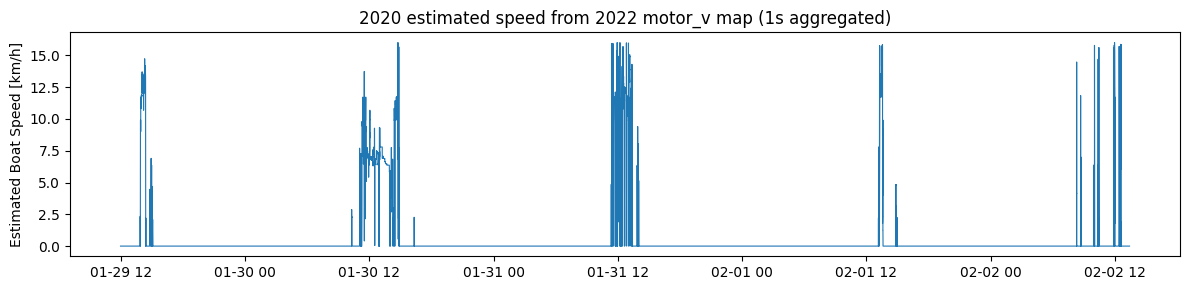

In [9]:
path_2020 = '../boat_data_50ms.csv'

# Strict column names (no fallbacks)
duty_col_2020 = 'ESC Duty Cycle'
batt_v_col_2020 = 'Battery Pack Voltage'

df_2020 = pd.read_csv(path_2020, usecols=['timestamp', duty_col_2020, batt_v_col_2020])

df_2020['ts_s'] = df_2020['timestamp'].astype(str).str.slice(0, 19)
df_2020['duty'] = pd.to_numeric(df_2020[duty_col_2020], errors='coerce')
df_2020['batt_v_raw'] = pd.to_numeric(df_2020[batt_v_col_2020], errors='coerce')

# Drop rows where we cannot form motor_v
df_2020 = df_2020.dropna(subset=['duty', 'batt_v_raw'])

# Heuristic scaling to match 2022 batt_v units
# [ASSUMPTION] If median batt_v > 200, interpret as decivolts and scale by 0.1.
bv_med = float(np.nanmedian(df_2020['batt_v_raw'].to_numpy(dtype=float)))
batt_v_scale = 0.1 if bv_med > 200 else 1.0
print('2020 batt_v median (raw):', bv_med, '-> scale:', batt_v_scale)
print('motor_v domain [V]:', MOTOR_V_MIN, 'to', MOTOR_V_MAX)

df_2020['batt_v'] = df_2020['batt_v_raw'] * batt_v_scale
df_2020['motor_v'] = df_2020['duty'] * df_2020['batt_v']

mv = df_2020['motor_v'].to_numpy(dtype=float)
in_domain = np.isfinite(mv) & (mv >= MOTOR_V_MIN) & (mv <= MOTOR_V_MAX)
print('fraction of samples within domain:', float(np.nanmean(in_domain)))

df_2020['speed_est_kmh'] = speed_kmh_from_motor_v_2022(df_2020['motor_v'].to_numpy(dtype=float), clip=False)

df_2020_1s = df_2020.groupby('ts_s', sort=False).agg(
    duty_mean=('duty', 'mean'),
    batt_v_mean=('batt_v', 'mean'),
    motor_v_mean=('motor_v', 'mean'),
    speed_est_kmh=('speed_est_kmh', 'mean'),
    n=('speed_est_kmh', 'size'),
).reset_index()

df_2020_1s['timestamp'] = pd.to_datetime(df_2020_1s['ts_s'], errors='coerce')
df_2020_1s = df_2020_1s.sort_values('timestamp')

display(df_2020_1s.head())
display(df_2020_1s.describe())

plot_df = df_2020_1s.dropna(subset=['timestamp', 'speed_est_kmh'])
plt.figure(figsize=(12, 3))
plt.plot(plot_df['timestamp'].to_numpy(), plot_df['speed_est_kmh'].to_numpy(), linewidth=0.8)
plt.ylabel('Estimated Boat Speed [km/h]')
plt.title('2020 estimated speed from 2022 motor_v map (1s aggregated)')
plt.tight_layout()
plt.show()


In [10]:
# Plot already generated in the cell above.
# Keep this cell as a safe 'peek' cell.
if 'df_2020_1s' not in globals():
    raise NameError('df_2020_1s is not defined. Run the previous cell first.')
df_2020_1s.head()


,ts_s,duty_mean,batt_v_mean,motor_v_mean,speed_est_kmh,n,timestamp
0,2020-01-29 11:56:53,0.0,38.664608,0.0,0.0,7,2020-01-29 11:56:53
1,2020-01-29 11:56:54,0.0,38.628181,0.0,0.0,20,2020-01-29 11:56:54
2,2020-01-29 11:56:55,0.0,38.661155,0.0,0.0,20,2020-01-29 11:56:55
3,2020-01-29 11:56:56,0.0,38.661760,0.0,0.0,20,2020-01-29 11:56:56
4,2020-01-29 11:56:57,0.0,38.614917,0.0,0.0,20,2020-01-29 11:56:57


In [11]:
display(df_2020_1s.describe())

,duty_mean,batt_v_mean,motor_v_mean,speed_est_kmh,n,timestamp
count,121643.000000,121643.000000,121643.000000,121254.000000,121643.000000,121643
mean,0.090283,39.071283,3.311356,1.746785,19.998586,2020-01-31 16:46:44.536463104
min,0.000000,25.958081,0.000000,0.000000,2.000000,2020-01-29 11:56:53
25%,0.000000,37.677105,0.000000,0.000000,20.000000,2020-01-30 15:06:33.500000
50%,0.000000,38.588646,0.000000,0.000000,20.000000,2020-01-31 14:30:33
75%,0.000000,39.689746,0.000000,0.000000,20.000000,2020-02-01 18:13:28.500000
max,1.000000,49.405243,36.193236,16.013783,20.000000,2020-02-02 13:25:43
std,0.195517,3.066305,7.028420,3.738725,0.126993,NaN
